In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
def testscore(predtmp,oritmp):
    score=1
    pred=np.ravel(predtmp)
    ori=np.ravel(oritmp)
    n=0
    for i in range(len(pred)):
        if ori[i]!=0:
            n=n+1
    print(n)
    for i in range(len(pred)):
        if ori[i]!=0:
            score=score-1/n*abs(pred[i]-ori[i])/abs(ori[i])
            #print(abs(pred[i]-ori[i])/abs(ori[i]))
    print('score:')
    print(score)
    return score

In [3]:

file_path = os.path.join('D:\\', 'hotaidata','sr_C6_01')
x=[]
y=[]
vx=[]
vy=[]
isvalid=[]
xtmp=[]
ytmp=[]
vxtmp=[]
vytmp=[]
isvalidtmp=[]
for root,dirs,files in os.walk(file_path):
    #print(root)
    
    for dir in dirs:
        #print(os.path.join(root,file))

            with open(os.path.join(root,dir,'B00001.dat'), 'r') as f:  
                lines = f.readlines()
                for line in lines[3:]: 
                    num=line.split()
                    xtmp.append(float(num[0]))
                    ytmp.append(float(num[1]))
                    vxtmp.append(float(num[2]))
                    vytmp.append(float(num[3]))
                    isvalidtmp.append(float(num[4]))

            x.append(np.array(xtmp).reshape(25,25))
            y.append(np.array(ytmp).reshape(25,25))
            vx.append(np.array(vxtmp).reshape(25,25))
            vy.append(np.array(vytmp).reshape(25,25))
            isvalid.append(np.array(isvalidtmp).reshape(25,25))
            xtmp=[]
            ytmp=[]
            vxtmp=[]
            vytmp=[]
            isvalidtmp=[]
#
x=np.array(x)
y=np.array(y)
vx=np.array(vx)
vy=np.array(vy)
isvalid=np.array(isvalid)

x=x.T
y=y.T
vx=vx.T
vy=vy.T
#print(x[0,:,:])
t=np.linspace(0,60/800,121)

dt=t[1]-t[0]
t=t[80:120]


In [4]:



spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T
'''
print('spatial_grid')
print(spatial_grid.shape)
print(spatial_grid)
'''

n=25

u=np.zeros((n,n,121, 2))

u[:, :, :, 0] = vx
u[:, :, :, 1] = vy
u_train=u[:,:,80:120,:]

'''
u_train[:, :, :, 0] = x
u_train[:, :, :, 1] = y
'''
u_dot_train = ps.FiniteDifference(axis=2)._differentiate(u_train, dt)
#print(u_dot_train[10,10])
tmp=u_train+u_dot_train*dt
testscore(tmp[:,:,:len(t)-1],u_train[:,:,1:])
#testscore(u_dot_train,u_test)

24142
score:
-1.2130797901651047


-1.2130797901651047

In [5]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.
library_functions = [
    lambda y: y,
    lambda x: x * x * x,

    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda y: y,
    lambda x: x + x + x,

    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    periodic=True
)


# Again, loop through all the optimizers
#print('STLSQ model: ')
print('u_train')
print(u_train.shape)



'''
print('SINDy')
model = ps.SINDy(feature_names=['Vx','Vy'])

model.fit(u_train, x_dot=u_dot_train)
model.print()
u_dot_stlsq = model.predict(u_train)
'''
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, 
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])
model.fit(u_train, x_dot=u_dot_train)
model.print()
'''
print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])
model.fit(u_train, t=dt)
model.print()


print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)

model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train)
model.print()'''

u_train
(25, 25, 40, 2)
STLSQ model: 
(Vx)' = 163.907 1 + 7.614 Vx + 27.911 Vy + 0.484 VxVxVx + -0.001 VyVyVy + -0.388 VxVyVy + -0.733 VxVxVy + 248.712 Vx_2 + 18.536 Vy_2 + 56.829 Vx_22 + 239.944 Vy_22 + 92.960 Vx_1 + -135.065 Vy_1 + 476.516 Vx_12 + -122.470 Vy_12 + 130.995 Vx_11 + -56.998 Vy_11 + -10.557 VxVx_2 + -170.210 VxVy_2 + 0.133 VyVx_2 + 0.199 VyVy_2 + 0.485 VxVxVxVx_2 + 1.244 VxVxVxVy_2 + 123.244 VyVyVyVx_2 + 13.507 VyVyVyVy_2 + -0.851 VxVyVyVx_2 + -0.105 VxVyVyVy_2 + -0.130 VxVxVyVx_2 + 0.414 VxVxVyVy_2 + -18.334 VxVx_22 + 36.633 VxVy_22 + -0.112 VyVx_22 + -0.135 VyVy_22 + -0.011 VxVxVxVx_22 + -0.074 VxVxVxVy_22 + 56.095 VyVyVyVx_22 + 12.772 VyVyVyVy_22 + -1.387 VxVyVyVx_22 + -0.042 VxVyVyVy_22 + -0.287 VxVxVyVx_22 + -0.586 VxVxVyVy_22 + -13.422 VxVx_1 + 56.607 VxVy_1 + 0.267 VyVx_1 + 0.010 VyVy_1 + -0.352 VxVxVxVx_1 + -0.217 VxVxVxVy_1 + -11.697 VyVyVyVx_1 + -4.503 VyVyVyVy_1 + 0.692 VxVyVyVx_1 + -0.026 VxVyVyVy_1 + -0.231 VxVxVyVx_1 + 0.238 VxVxVyVy_1 + -69.154 VxVx_12 + -

"\nprint('SR3 model, L0 norm: ')\noptimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,\n                   thresholder='l0', normalize_columns=True)\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])\nmodel.fit(u_train, t=dt)\nmodel.print()\n\n\nprint('SR3 model, L1 norm: ')\noptimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,\n                   thresholder='l1', normalize_columns=True)\n\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)\nmodel.fit(u_train, x_dot=u_dot_train)\nmodel.print()"

In [6]:
t_test=np.arange(0,25,1)
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(u_train)
print(x_dot_test_predicted.shape)
#print(x_dot_test_predicted[0])
#print(x_dot_test_predicted.shape)
dottmp=np.array(x_dot_test_predicted)
pltpredict=u_train+dottmp*dt

(25, 25, 40, 2)


In [7]:
print(pltpredict[:,:,:39,:].shape)

(25, 25, 39, 2)


In [8]:

# Make fancy plot comparing derivative
plt.figure(figsize=(4, 4))
#plt.subplot(1, 3, 1)

print(x.shape)

'''
print(plttestvx[0].shape)
print(plttestvx[0])

print(y.shape)
print(y[0,:,0])
ytmp=y[0,:,0]
ytmp=ytmp[::-1]
plt.figure(figsize=(4, 4))
plt.streamplot(x[0][0],ytmp,vx_dot[:,:,0],vy_dot[:,:,0])

plt.show()
'''
print('x')
print(x[0].shape)
print('vx_dot[:,:,i]')
#print(vx_dot[:,:,i].shape)
print('pltpredict')


u_train=u_train[:,:,:,:]
pltpredict=pltpredict[:,:,:,:]
print(pltpredict.shape)
print(u_train.shape)
print('score')
print(testscore(pltpredict,u_train))
print('is')
print(len(t))

(25, 25, 121)
x
(25, 121)
vx_dot[:,:,i]
pltpredict
(25, 25, 40, 2)
(25, 25, 40, 2)
score
24762
score:
0.5922582921537191
0.5922582921537191
is
40


<Figure size 400x400 with 0 Axes>

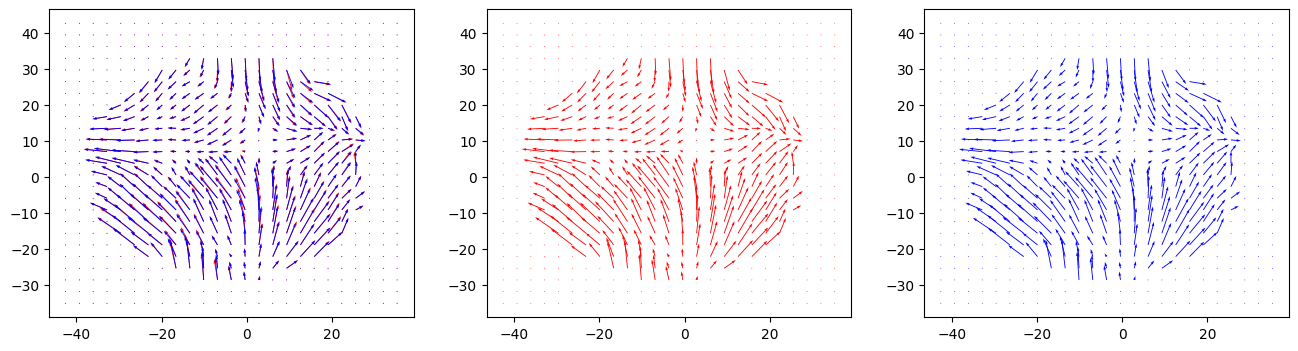

score
620
score:
0.5140254528241756
0.5140254528241756


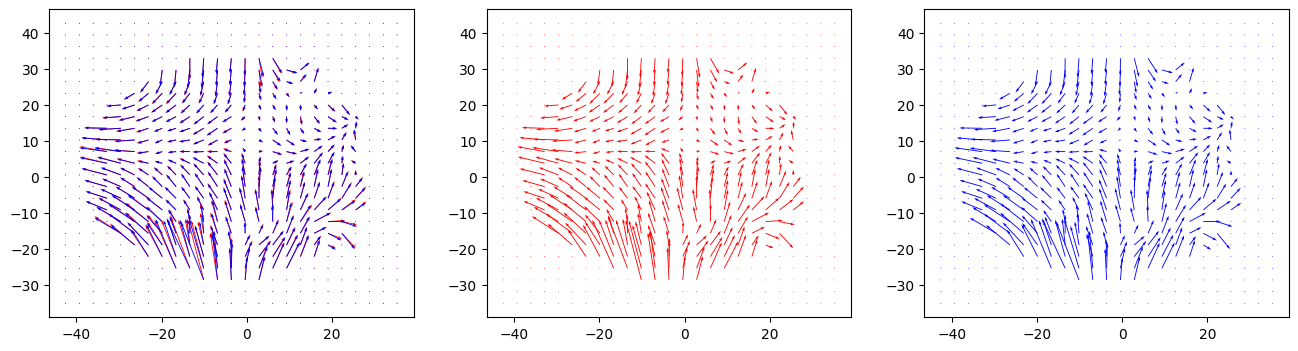

score
618
score:
0.8620475151397494
0.8620475151397494


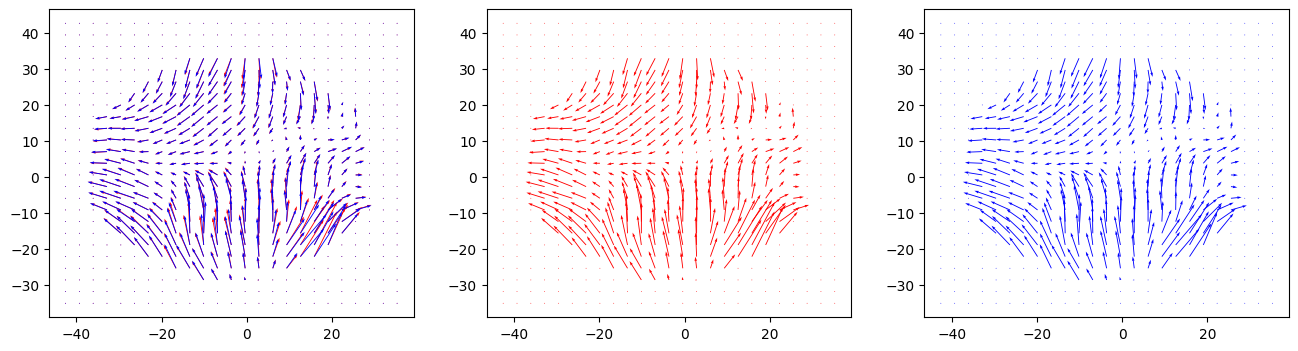

score
620
score:
0.7559786370585692
0.7559786370585692


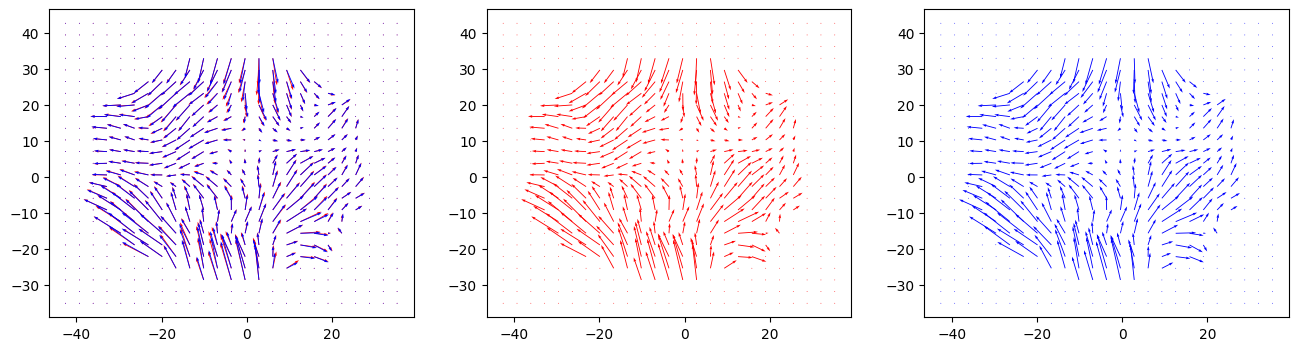

score
618
score:
0.8840993548880666
0.8840993548880666


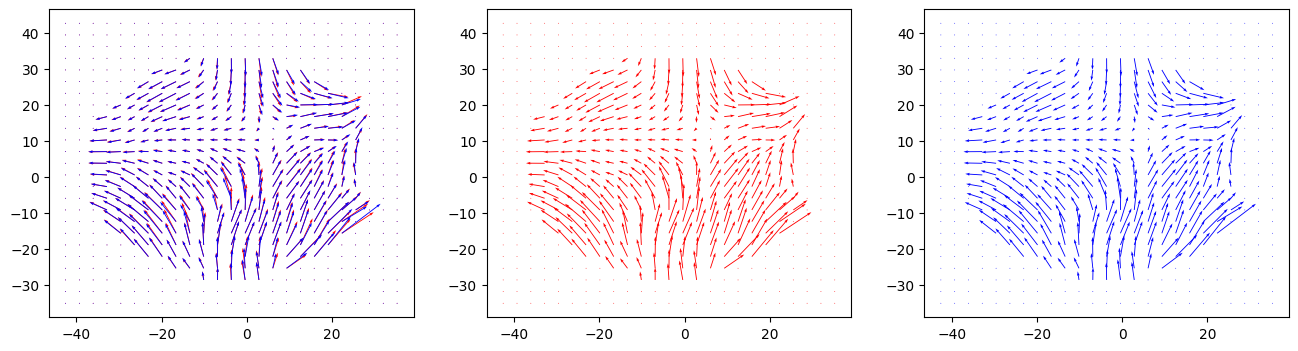

score
618
score:
0.7078647178564526
0.7078647178564526


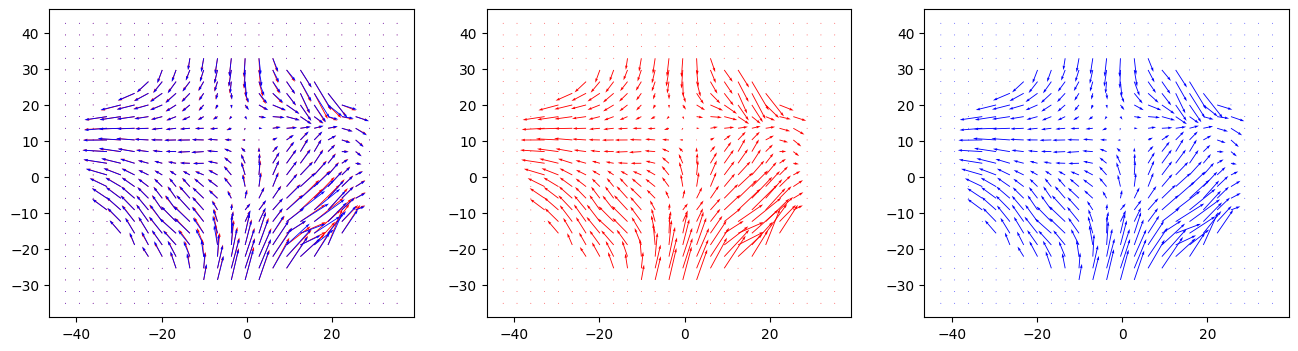

score
620
score:
0.82164199884299
0.82164199884299


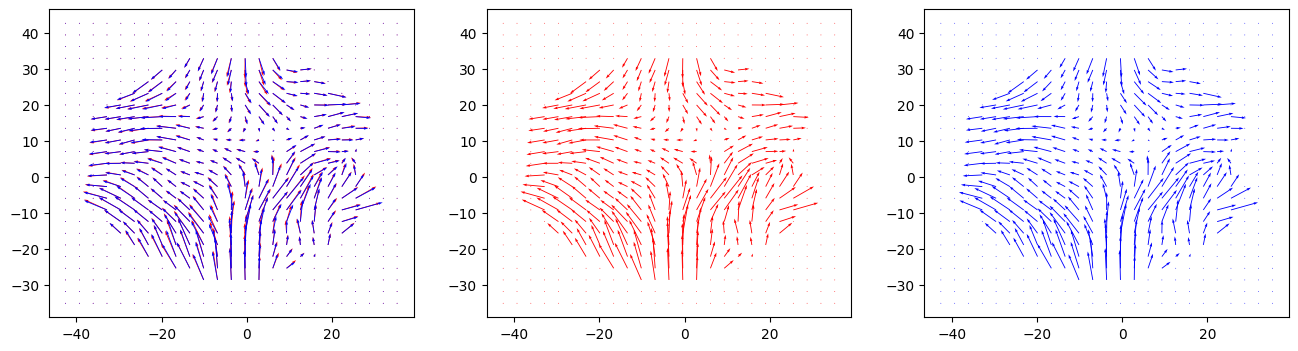

score
620
score:
-5.357856752983413
-5.357856752983413


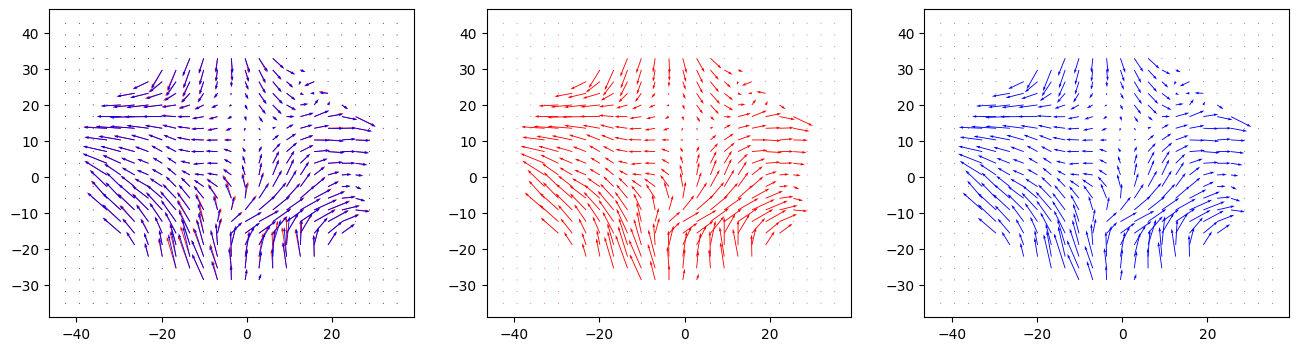

score
618
score:
0.3720564142265256
0.3720564142265256


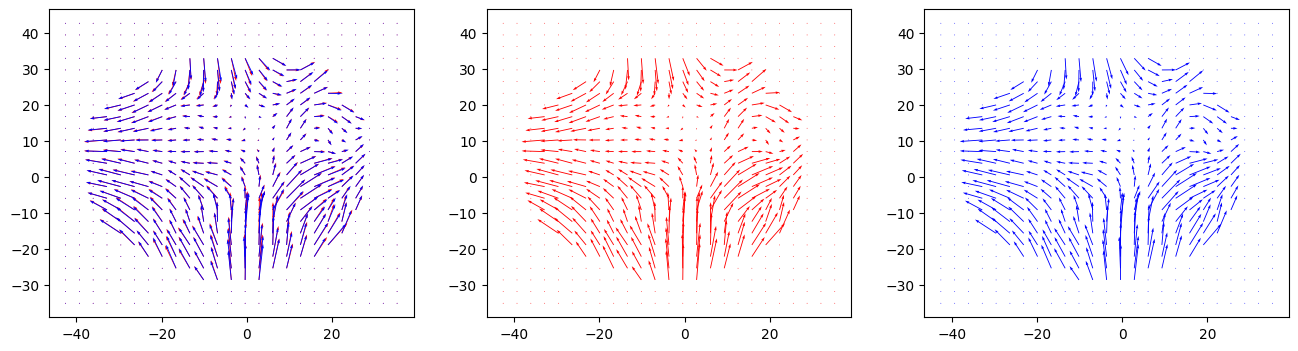

score
620
score:
0.7555852180583738
0.7555852180583738


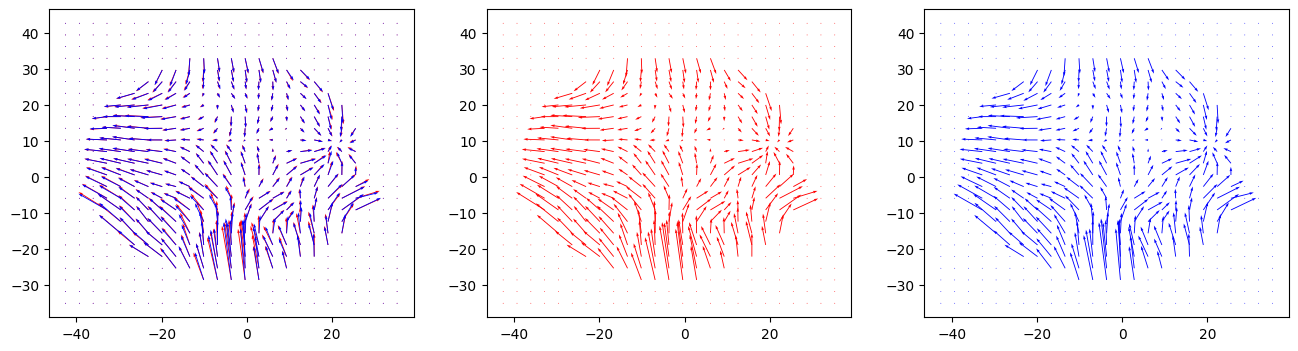

score
618
score:
0.7882727060087675
0.7882727060087675


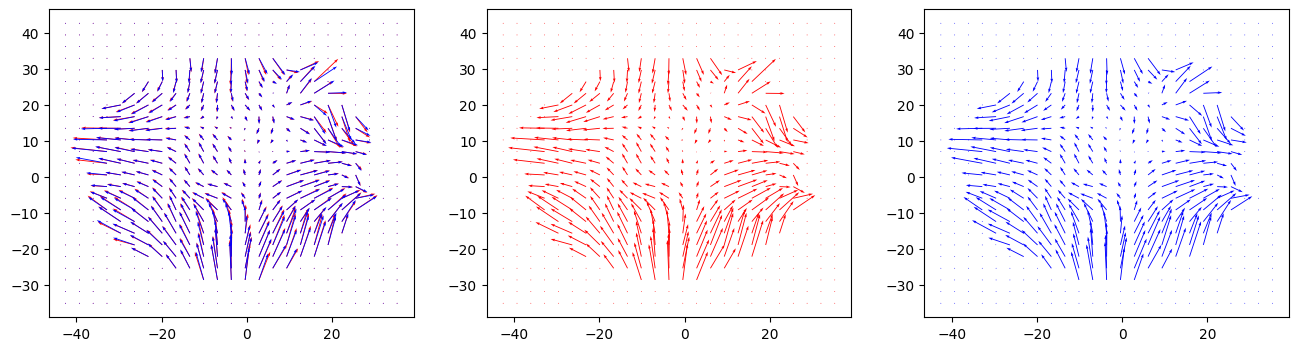

score
618
score:
0.880953240456327
0.880953240456327


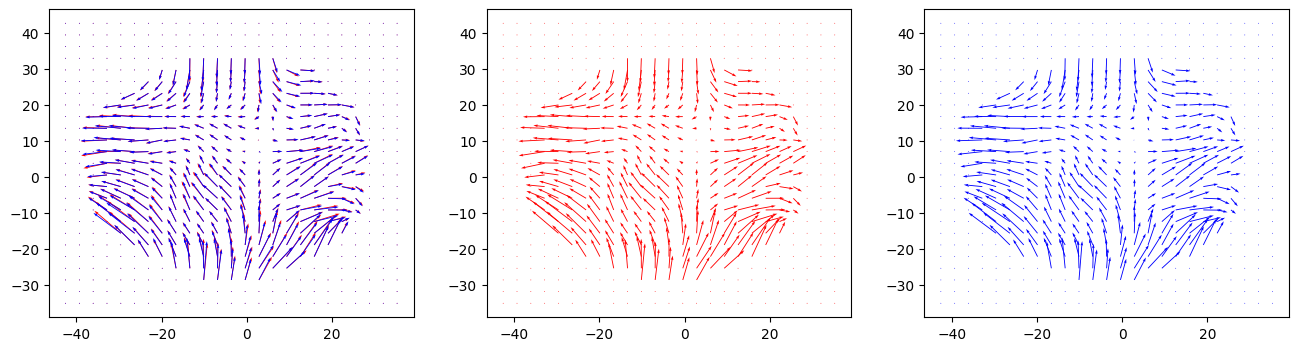

score
620
score:
0.7639982287601279
0.7639982287601279


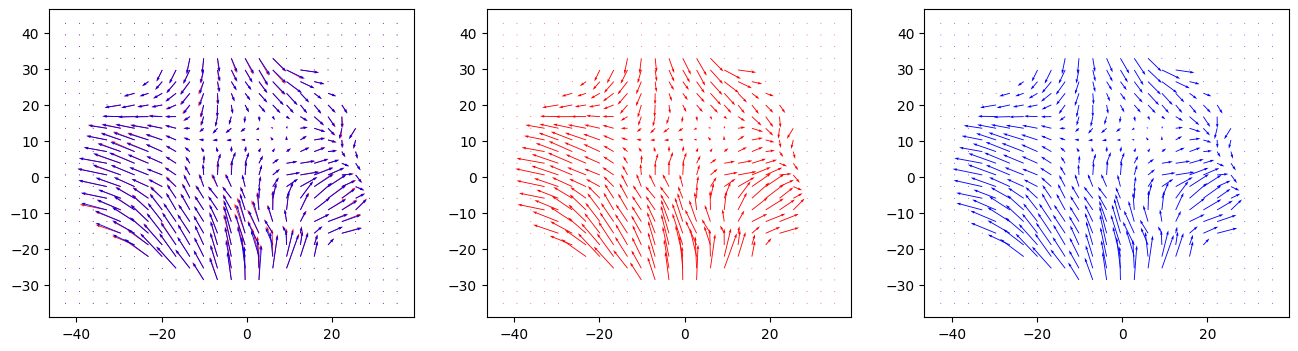

score
616
score:
0.7809481895732197
0.7809481895732197


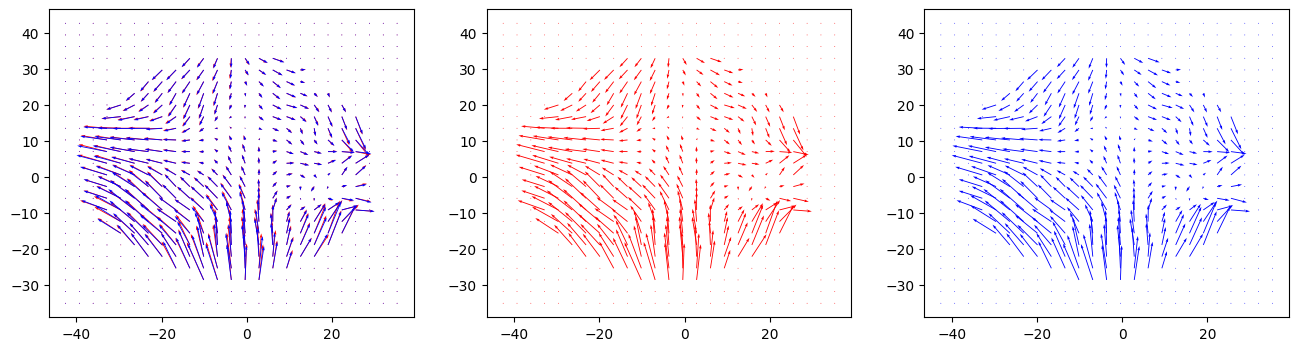

score
618
score:
0.8440451440993705
0.8440451440993705


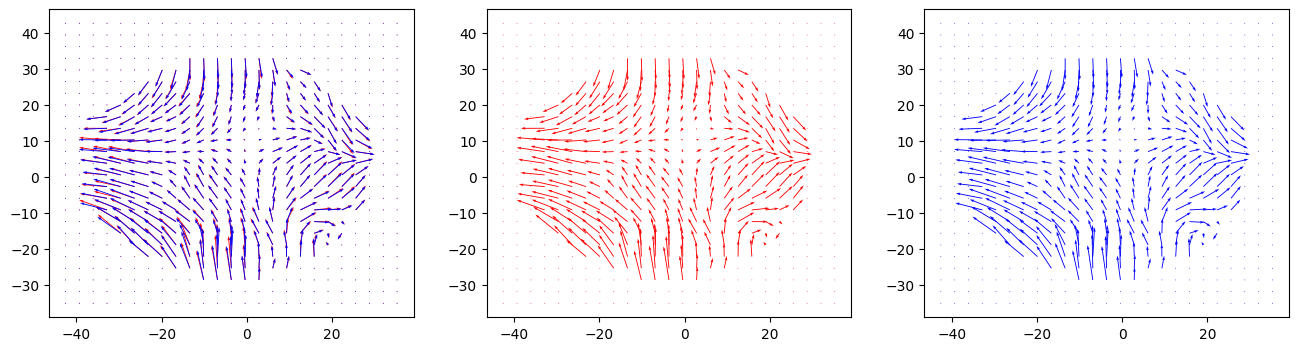

score
620
score:
0.8118642907953297
0.8118642907953297


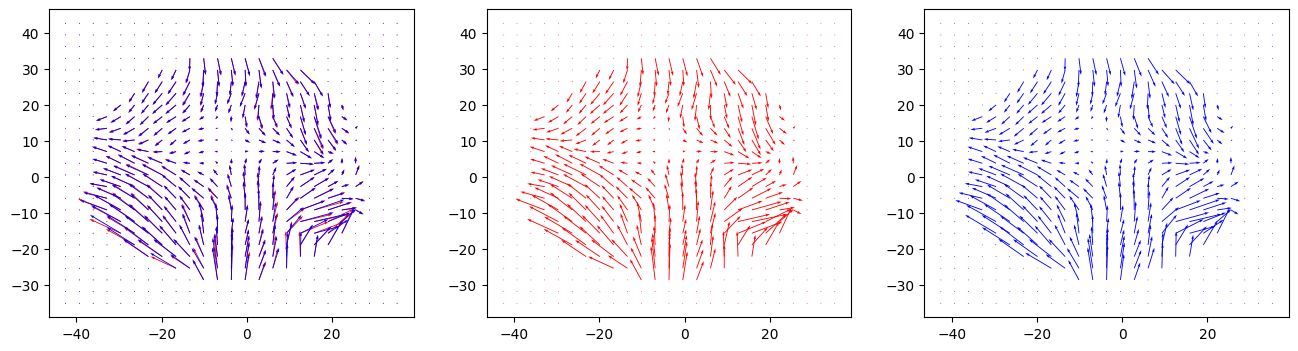

score
618
score:
0.6325280085571496
0.6325280085571496


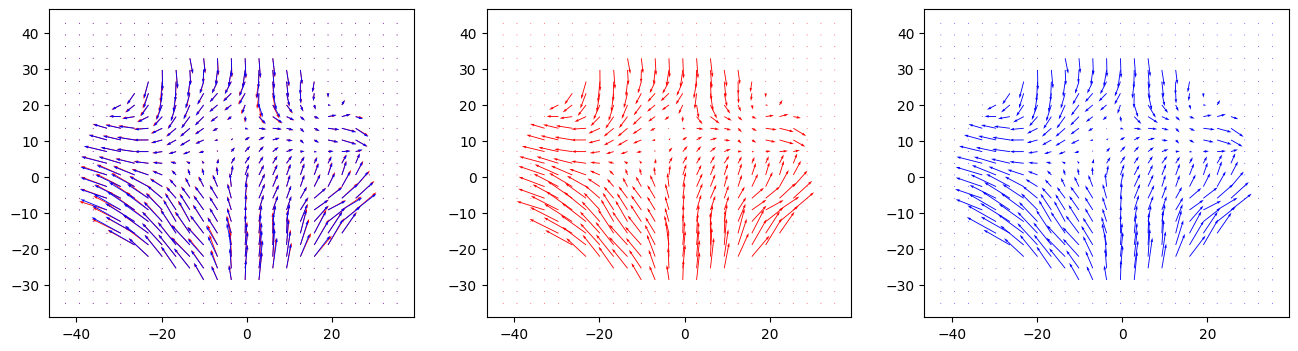

score
618
score:
0.8731194532578912
0.8731194532578912


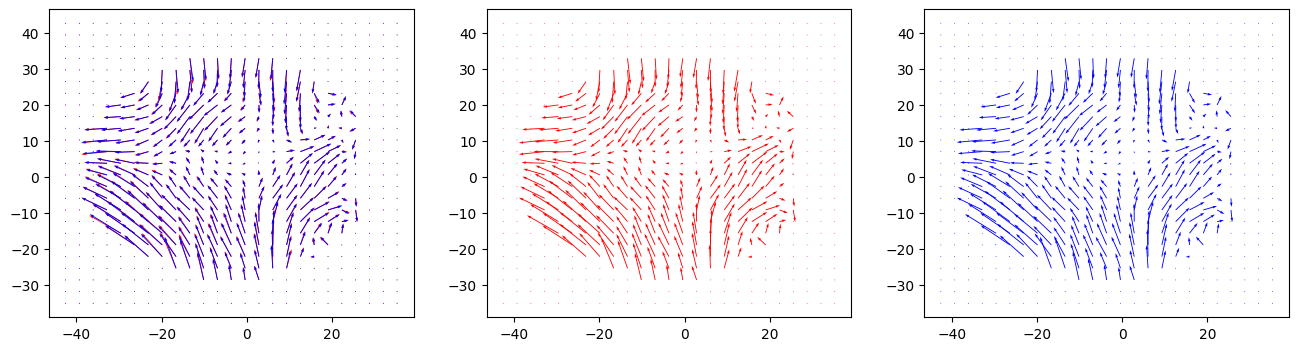

score
618
score:
0.6689795187362932
0.6689795187362932


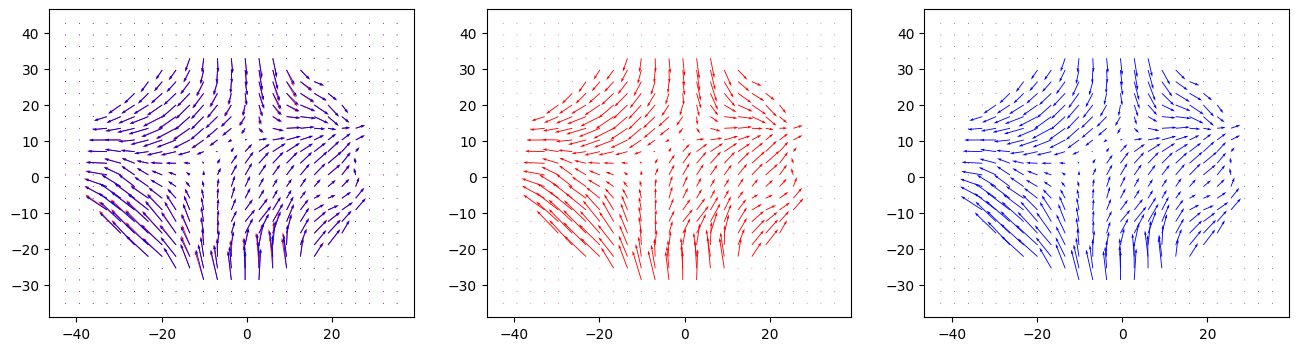

score
618
score:
0.9030721629156824
0.9030721629156824


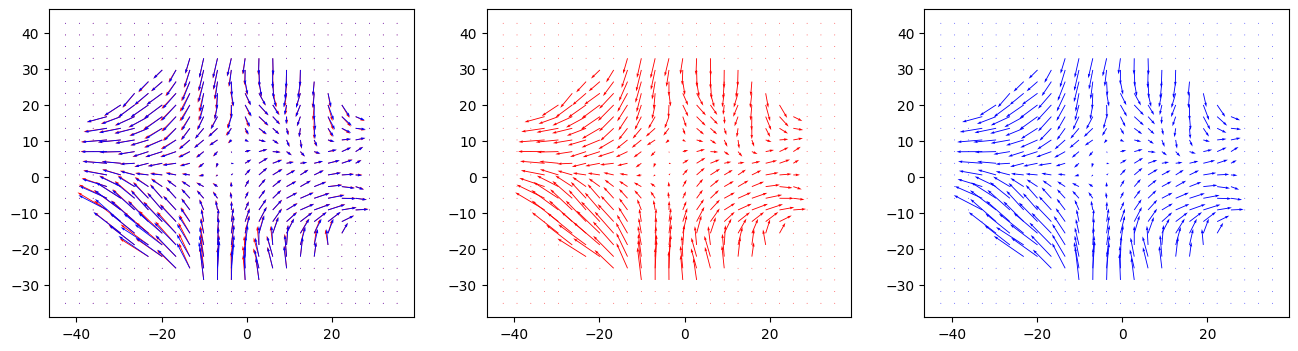

score
620
score:
0.5320420130471137
0.5320420130471137


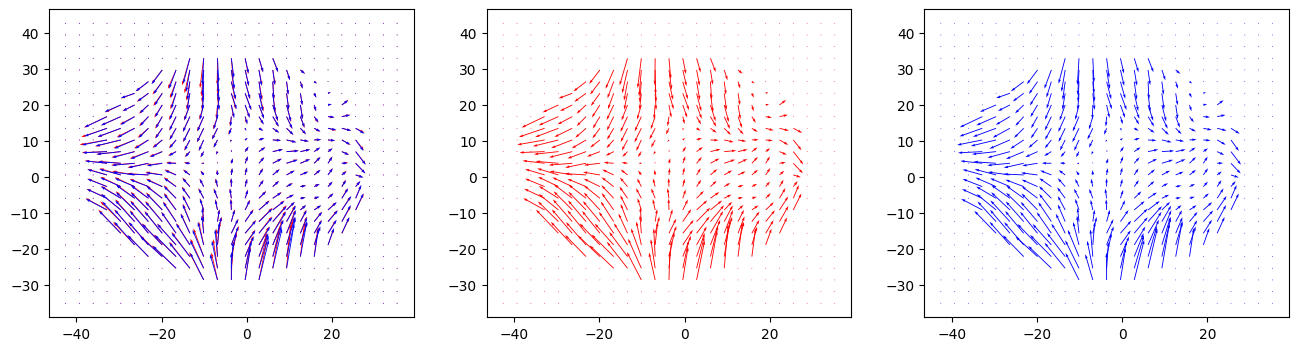

score
618
score:
0.900378489339603
0.900378489339603


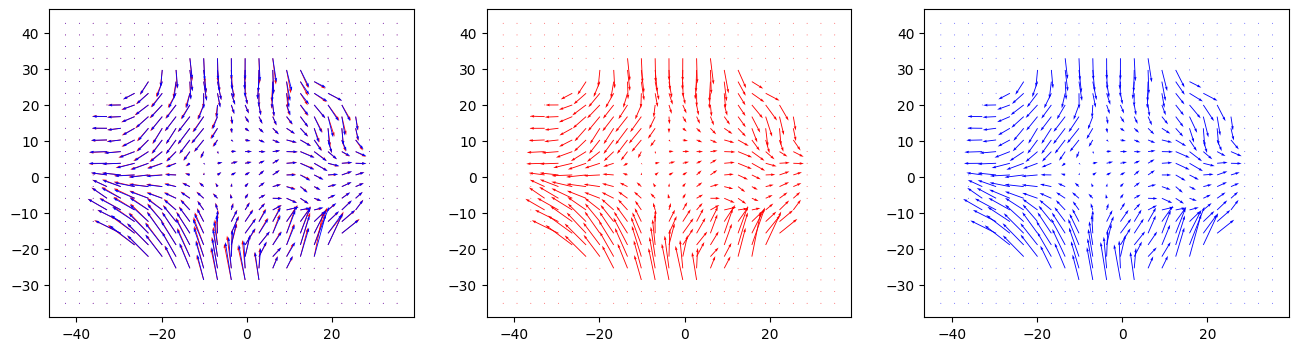

score
620
score:
-0.0033035993129505448
-0.0033035993129505448


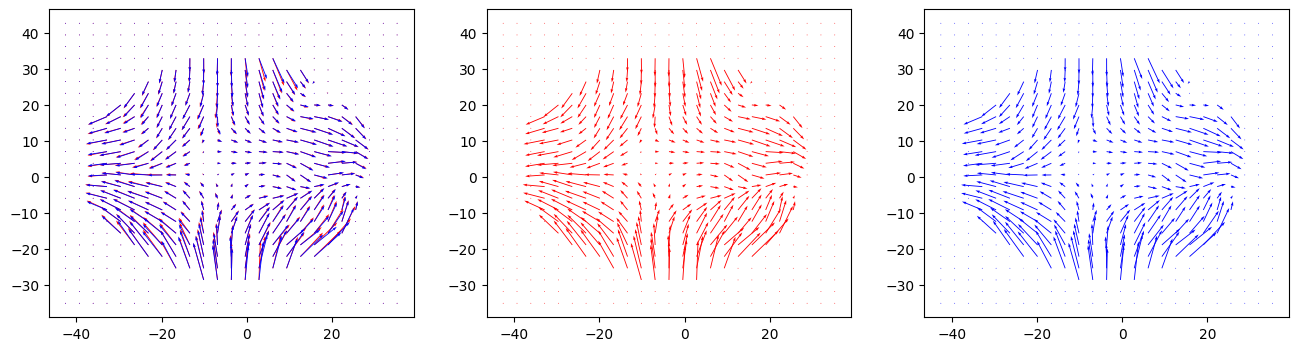

score
620
score:
0.8802165716403884
0.8802165716403884


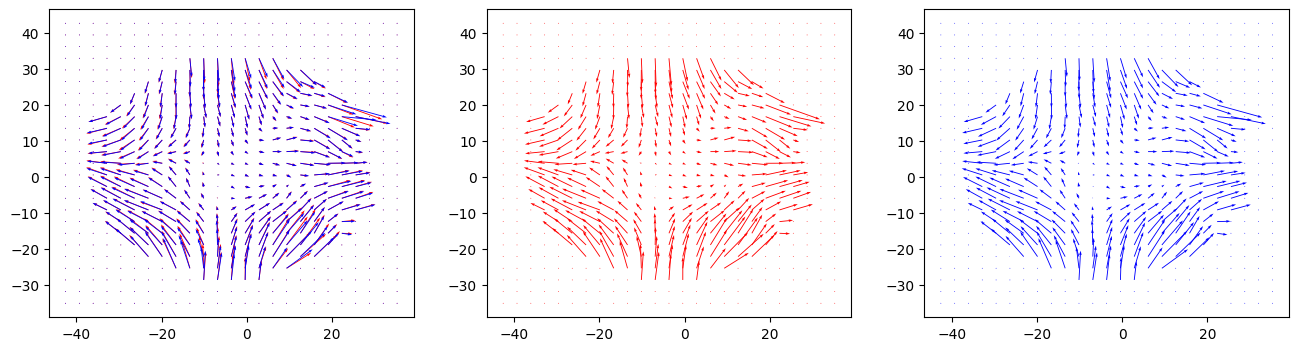

score
620
score:
0.8460121364494548
0.8460121364494548


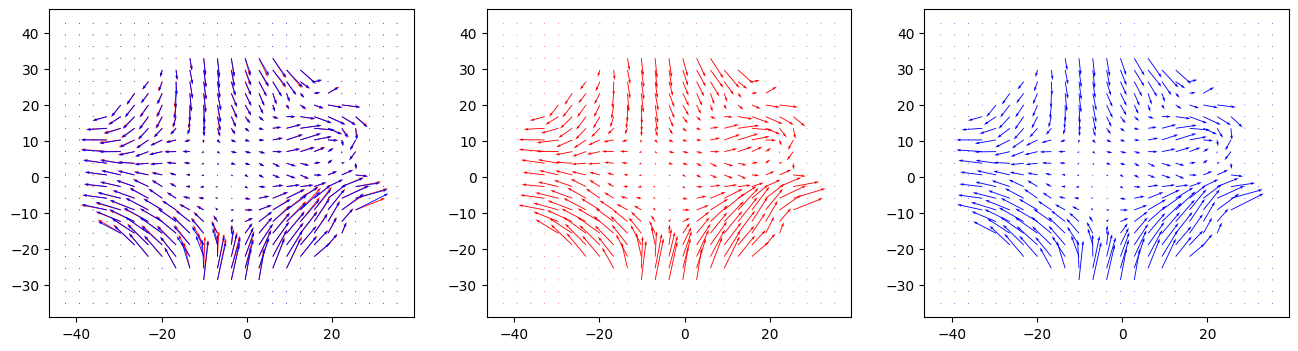

score
620
score:
0.8520719804239237
0.8520719804239237


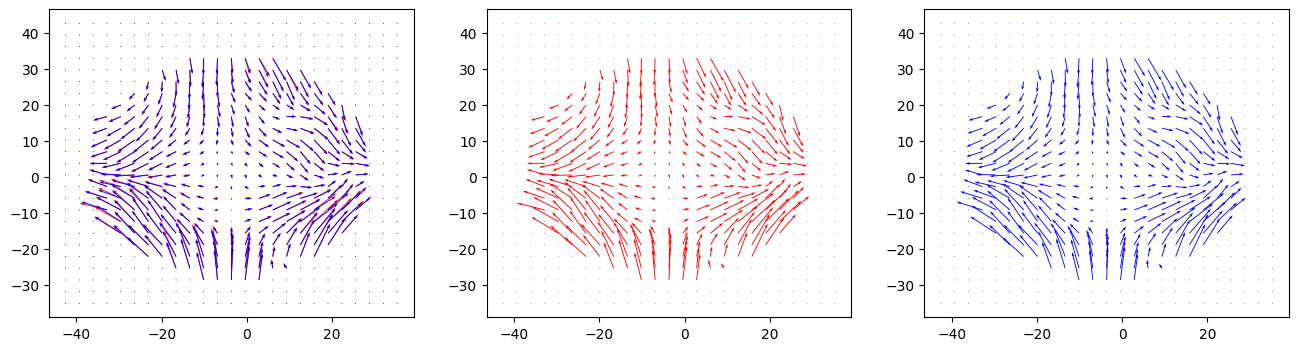

score
620
score:
0.8483229512463527
0.8483229512463527


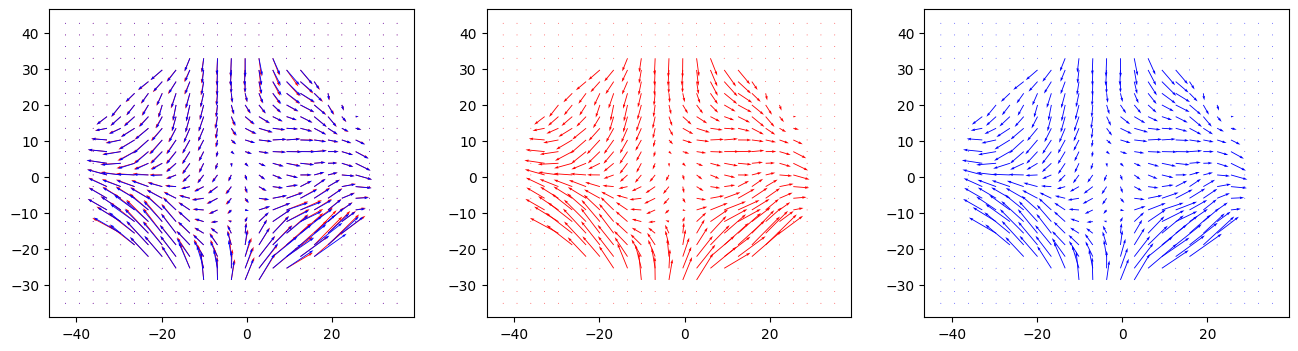

score
620
score:
0.8772512389345144
0.8772512389345144


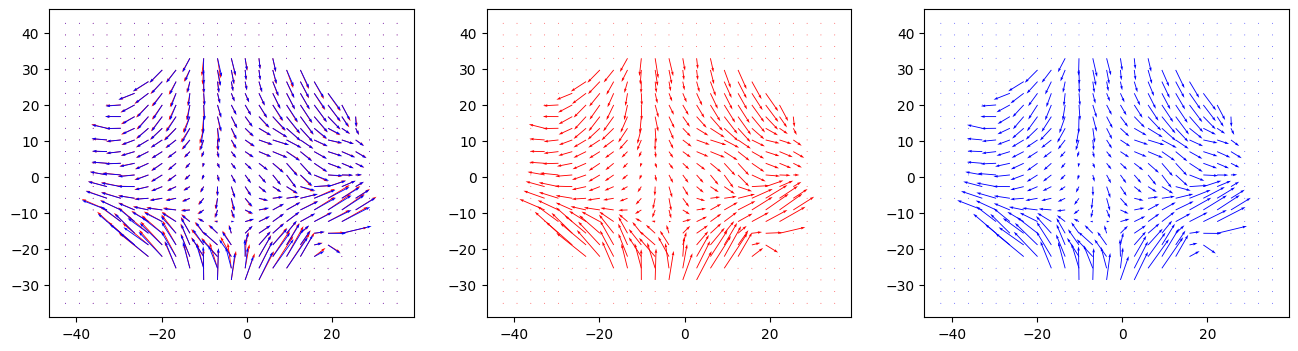

score
618
score:
0.8412520975297467
0.8412520975297467


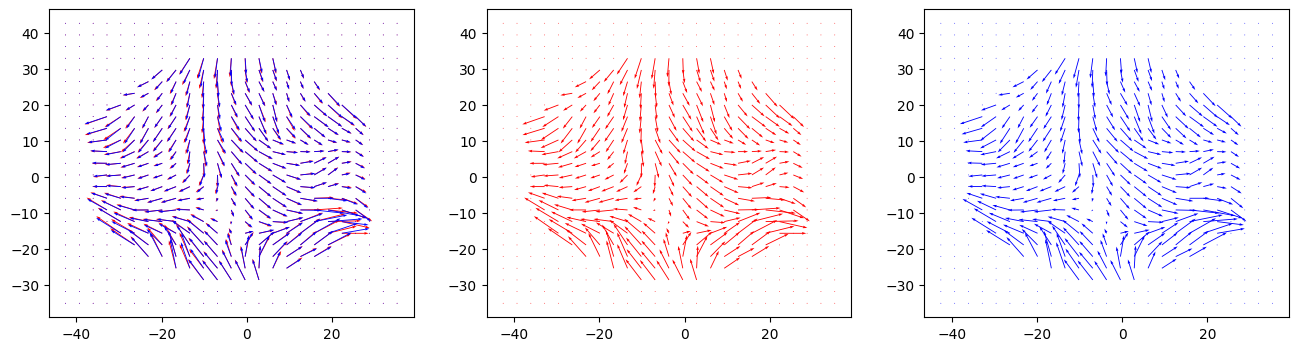

score
620
score:
0.6041742215194217
0.6041742215194217


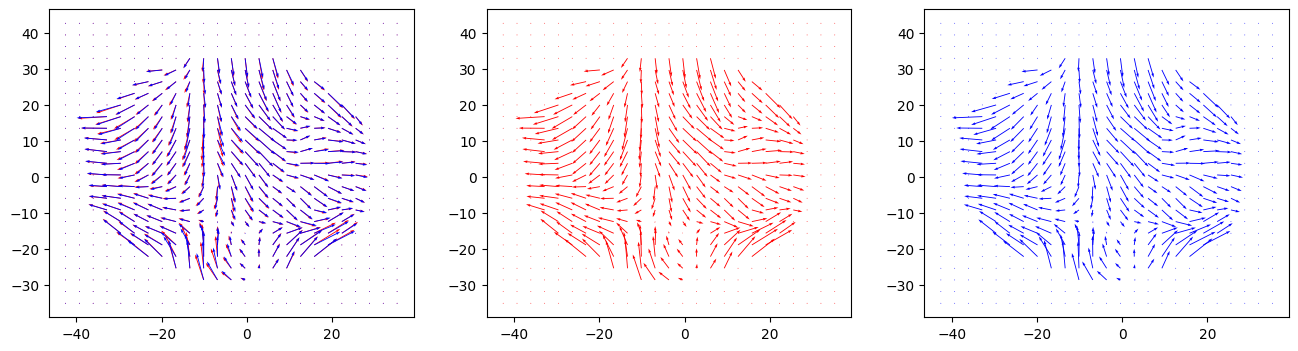

score
620
score:
0.868658355913583
0.868658355913583


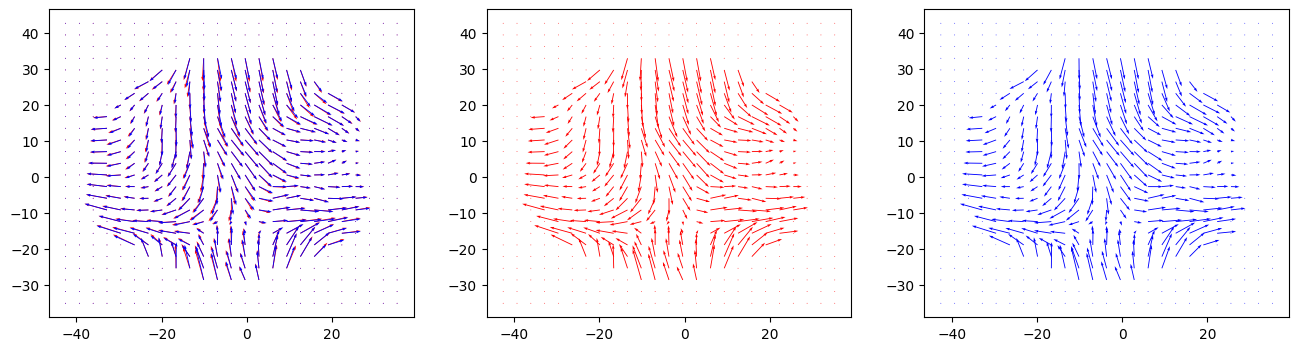

score
620
score:
0.7728575675497504
0.7728575675497504


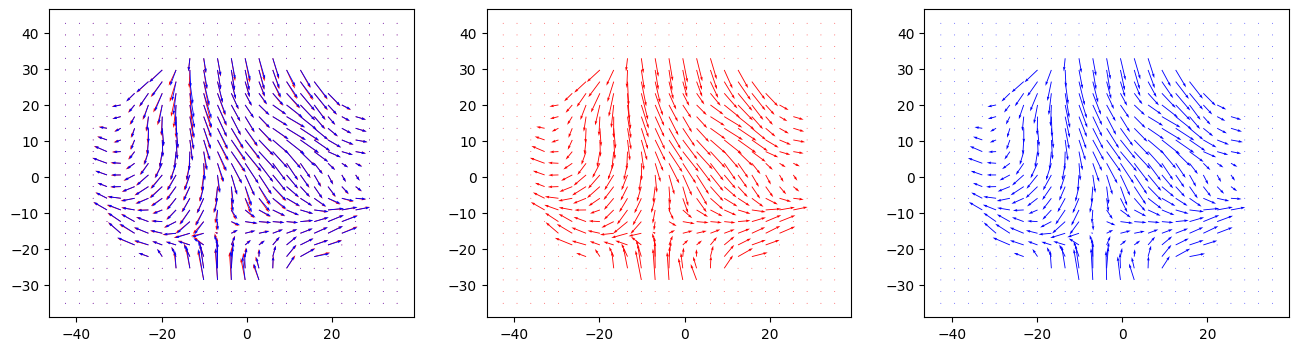

score
618
score:
0.8782878819479815
0.8782878819479815


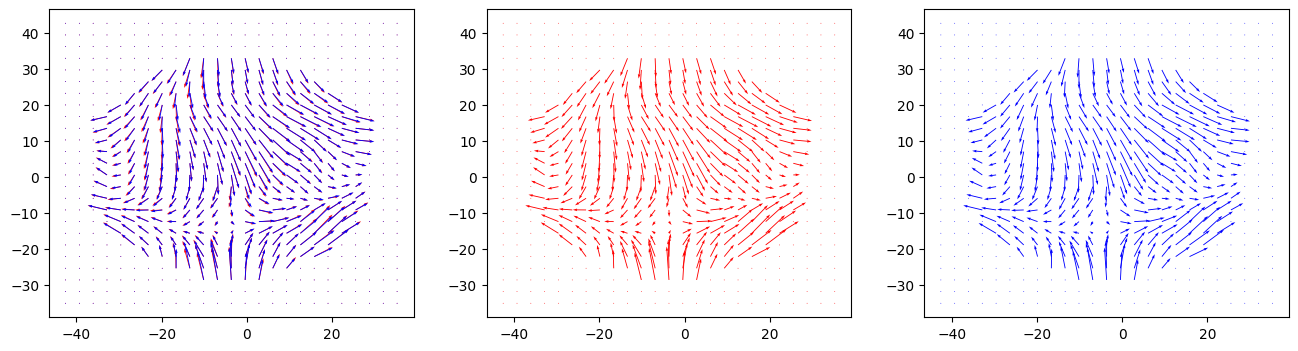

score
620
score:
0.8828548037399009
0.8828548037399009


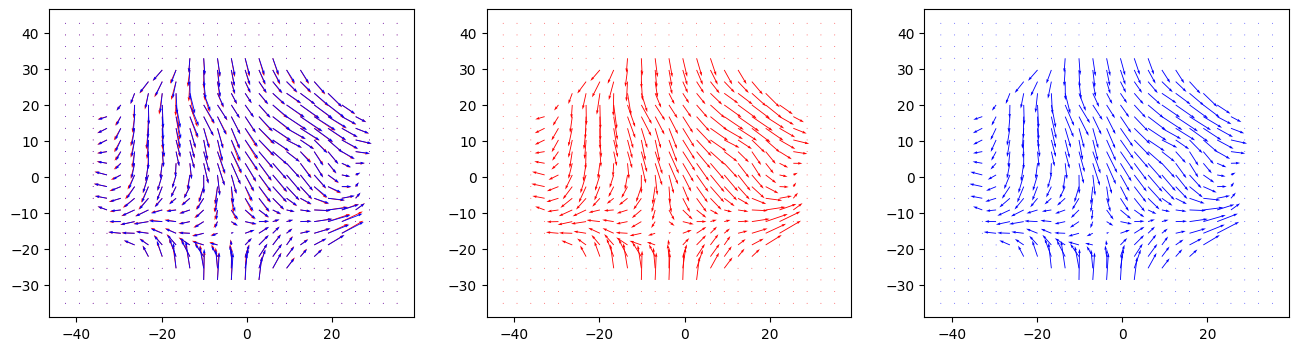

score
620
score:
0.856006016608694
0.856006016608694


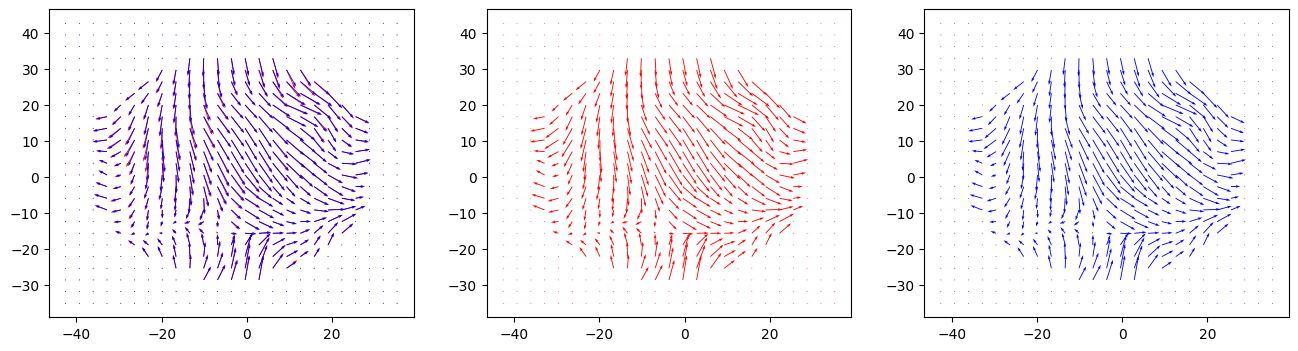

score
620
score:
0.6670447421394239
0.6670447421394239


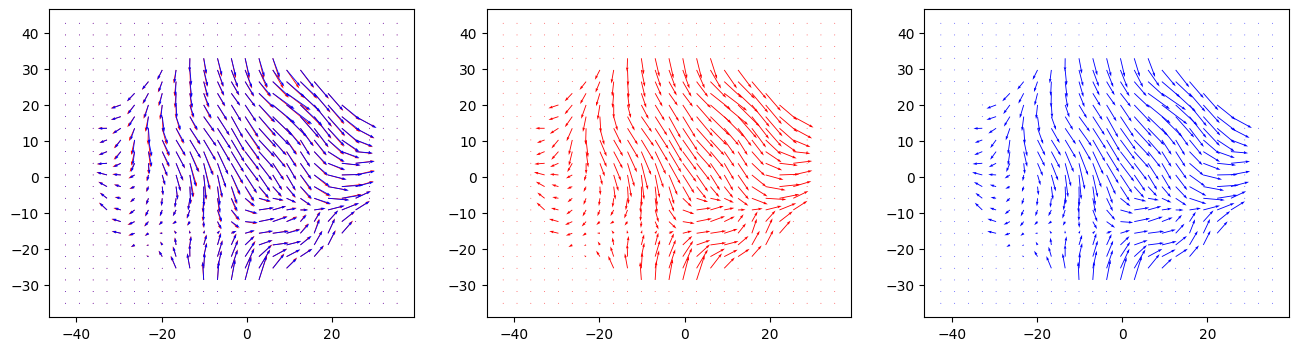

score
618
score:
-0.03840739743792046
-0.03840739743792046


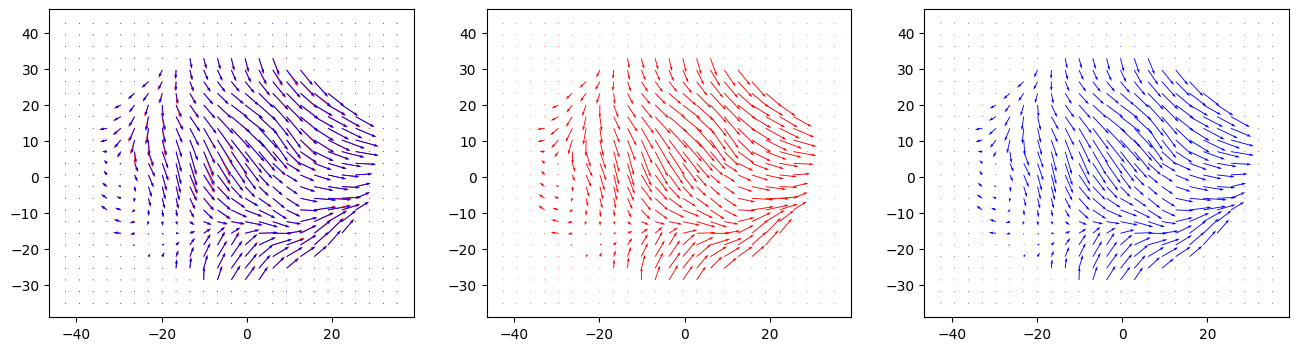

score
618
score:
0.8703827156782361
0.8703827156782361


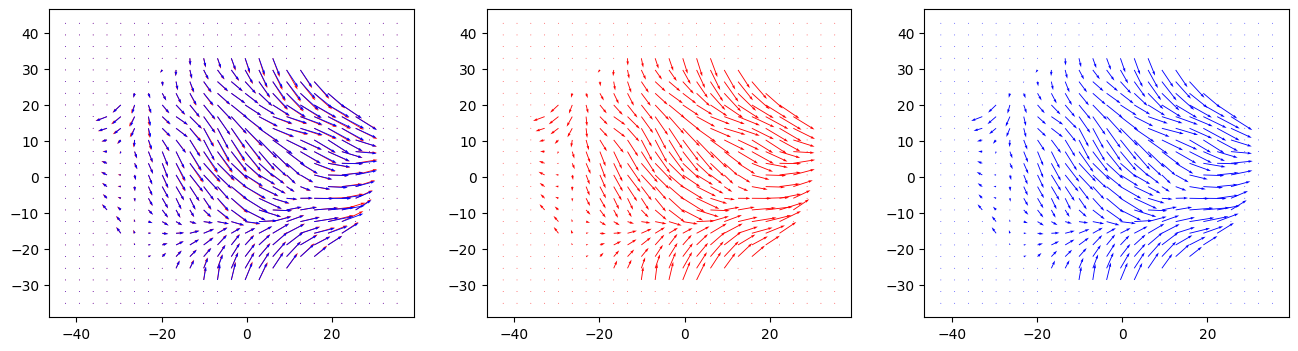

score
620
score:
0.8523624340956666
0.8523624340956666


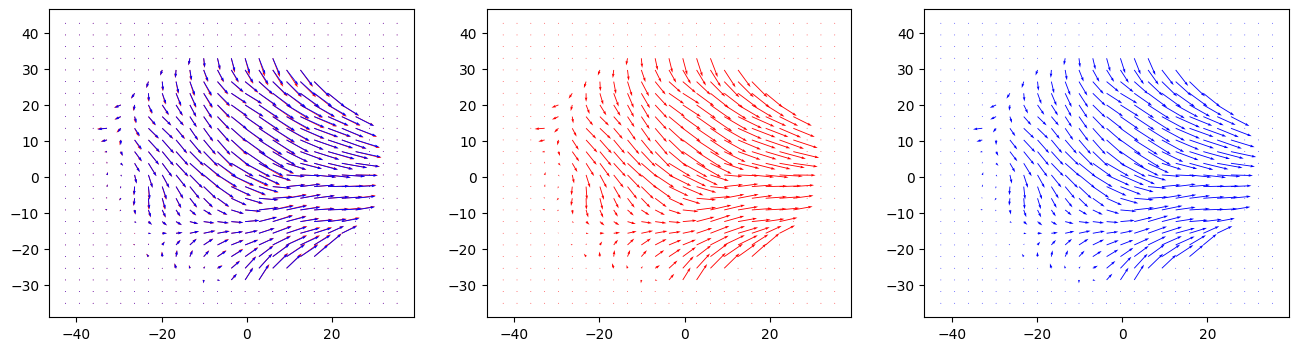

score
618
score:
0.8534664624865123
0.8534664624865123


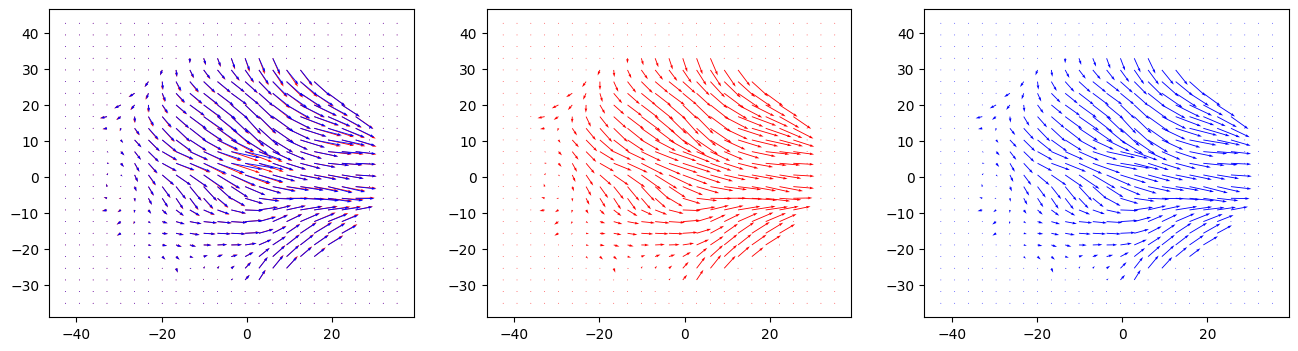

score
620
score:
0.7949551722924653
0.7949551722924653


In [9]:
for i in range(40):
    u_dot_train[:,:,i,0]
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_train[:,:,i,0],u_train[:,:,i,1],color='r')
    plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.subplot(1, 3, 2)
    plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_train[:,:,i,0],u_train[:,:,i,1],color='r')
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.subplot(1, 3, 3)
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
    plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.show()
    print('score')
    print(testscore(pltpredict[:,:,i,],u_train[:,:,i,:]))
